<a href="https://colab.research.google.com/github/matwirabc/binaproject/blob/robin/zug/BINA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Ziele definieren & Informationsbedarf klären**

Der öffentliche Verkehr spielt eine zentrale Rolle in der Schweizer Mobilitätspolitik. Besonders die Nutzung von Bahnhöfen sowie der Besitz von General- und Halbtaxabonnementen spiegeln das Mobilitätsverhalten der Bevölkerung wieder. Ziel dieser Arbeit ist es, die Entwicklung dieser Indikatoren im Zeitraum 2013–2023 zu untersuchen und kantonale Unterschiede in Relation zur gesamtschweizerischen Entwicklung aufzuzeigen. Zudem möchte der Bund verstehen, ob eine Beziehung zwischen den Abozahlen der Nutzung der Bahnhöfe vorliegt. Im Fokus steht dabei der Vergleich absoluter Veränderungen über die Jahre.

Dier Abschnnitt möchte die nachstehenden Forschungsfragen beantworten:
<br>

***F1:*** Wie hat sich die Nutzung von Bahnhöfen kantonal & gesammtschweizerisch entwickelt zwischen 2013 und 2024?
<br>
***F3:*** Wie haben sich die Abozahlen kantonal & gesammtschweizerisch entwickelt zwischen 2013 und 2024?
<br>
***F4:*** Welche Unterschiede zeigen sich zwischen den Kantonen bei der Entwicklung der Abozahlen im Vergleich zur nationalen Veränderung?
<br>
***F5:*** Welche Kantone weichen besonders stark vom nationalen Trend ab z.B. mit hoher Aboquote, aber geringer Bahnhofnutzung oder umgekehrt?
<br>
***F6*** Was sind die Trends für die Jahre 2023 bis 2026? <br>
***F6.1*** Bei den GA's? <br>
***F6.2*** Bei den Halbtax? <br>
***F6.3*** Bei den Bahnhofnutzer <br>
<br>
***F7:*** Gibt es einen Zusammenhang zwischen der Anzahl Generalabonnemente und der Bahnhofnutzung pro Kanton?

-> Geht eine höhere Bahnhofnutzung mit einer Steigerung der Abozahlen inher?
-> Können höhere Abozahlen ein Indikator sein, für steigende Bahnhofnutzung?
<br>
***F8:*** Entwickeln sich Halbtax- und GA-Abos parallel oder unabhängig voneinander?
<br>
# **2. Informationen beschaffen**
Die verwendeten Rohdaten wurden im Vorfeld von der Open-Data-Plattform der SBB bzw. von Swisstopo heruntergeladen und liegen im CSV-Format im Abgabeordner vor. Dadurch ist eine direkte Weiterverarbeitung in Python ohne externe API-Anbindung nötig.
<br>
- SBB. (2017, August 16). Generalabo / Halbtax – mit Bevölkerungsdaten. https://data.sbb.ch/explore/dataset/generalabo-halbtax-mit-bevolkerungsdaten/information/?flg=de-ch
- SBB. (n.d.). Anzahl SBB-Bahnhofbenutzer (Tagesverlauf). https://data.sbb.ch/explore/dataset/anzahl-sbb-bahnhofbenutzer-tagesverlauf/information/&disjunctive.isb_gi
- swisstopo. (2024, Januar 8). Amtliches Ortschaftenverzeichnis. Bundesamt für Landestopografie. https://www.swisstopo.admin.ch/de/amtliches-ortschaftenverzeichnis

<br>

# **3. Daten analysieren**






In [33]:
#Laden und Importieren der Libaries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objs as go
from scipy.stats import pearsonr
from scipy.stats import pearsonr, linregress

## Einlesen der Dateien
Die daten werden eingelesen und initial geprüft.

In [34]:

# Bahnhöfe
df = pd.read_csv("anzahlbahnhof.csv")

# Abos & Halbtax
abos_df = pd.read_excel("abos.xlsx")

# Abos & Halbtax
plz_df = pd.read_excel("ortsverzeichnis.xlsx", skiprows=1)

# Ausgabe prüfen
print(plz_df.head())
print(plz_df.columns)

print(abos_df.head())
print(abos_df.columns)

print(df.head())
print(df.columns)

       Ortschaftsname   PLZ  Zusatzziffer        Gemeindename  BFS-Nr  \
0     Aeugst am Albis  8914             0     Aeugst am Albis       1   
1         Aeugstertal  8914             2     Aeugst am Albis       1   
2           Zwillikon  8909             0  Affoltern am Albis       2   
3  Affoltern am Albis  8910             0  Affoltern am Albis       2   
4          Bonstetten  8906             0          Bonstetten       3   

  Kantonskürzel            E            N Sprache    Validity  
0            ZH  2679402.872  1235842.010      de  2008-07-01  
1            ZH  2679815.372  1237404.310      de  2008-07-01  
2            ZH  2675280.133  1238108.286      de  2008-07-01  
3            ZH  2676852.012  1236929.718      de  2008-07-01  
4            ZH  2677412.150  1241078.278      de  2008-07-01  
Index(['Ortschaftsname', 'PLZ', 'Zusatzziffer', 'Gemeindename', 'BFS-Nr',
       'Kantonskürzel', 'E', 'N', 'Sprache', 'Validity'],
      dtype='object')
   Jahr   PLZ  Generala

## Bereinigung und Mapping auf die Kantone

berflüssige Spalten entfernt (z. B. „Unité“ bei den Bahnhöfen) und fehlende Werte bereinigt. Anschließend werden beide Datensätze – Bahnhofnutzung und Abonnementzahlen – über Bahnhofs- bzw. PLZ-Zuordnung jeweils auf die Kantone gemappt, sodass sie später kantonal aggregiert und verglichen werden können.

In [ ]:
##==== "anzahlbahnhof.csv" ====##

# CSV-Datei laden
df = pd.read_csv("anzahlbahnhof.csv")  # Lädt die CSV-Datei mit den Bahnhofdaten in ein DataFrame

# Fehlende Werte in der Spalte "Anzahl Bahnhofbenutzer" durch 0 ersetzen
df["Anzahl Bahnhofbenutzer"] = df["Anzahl Bahnhofbenutzer"].fillna(0)

# Spalte "Unité" wird nicht benötigt und daher entfernt
df = df.drop(columns=["Unité"])

# Gruppierung nach Jahr und Bahnhof (noch ohne Kanton!), Summe der Bahnhofbenutzer pro Jahr und Bahnhof
# => Der Kanton wird erst später zugeordnet, daher entsteht hier eine Zwischentabelle

# Mapping von Bahnhöfen zu Kantonen (Bahnhofnamen → Kanton)
ort_zu_kanton = {
    "Aarau": "AG", "Baden": "AG", "Basel SBB": "BS", "Bellinzona": "TI", "Bern": "BE", "Biel/Bienne": "BE",
    "Chur": "GR", "Fribourg/Freiburg": "FR", "Genève": "GE", "Genève-Aéroport": "GE", "Genève-Eaux-Vives": "GE",
    "Lausanne": "VD", "Lugano": "TI", "Luzern": "LU", "Neuchâtel": "NE", "Olten": "SO", "St. Gallen": "SG",
    "Thun": "BE", "Uster": "ZH", "Winterthur": "ZH", "Yverdon-les-Bains": "VD", "Zürich HB": "ZH",
    "Zürich Oerlikon": "ZH", "Zürich Stadelhofen": "ZH", "Zürich Altstetten": "ZH", "Zürich Enge": "ZH",
    "Zürich Hardbrücke": "ZH", "Zug": "ZG", "Sion": "VS", "Schaffhausen": "SH", "Burgdorf": "BE",
    "Solothurn": "SO", "Bulle": "FR", "Wil SG": "SG", "Locarno": "TI", "Romanshorn": "TG", "Sierre/Siders": "VS",
    "Gossau SG": "SG", "Kreuzlingen": "TG", "Martigny": "VS", "Brig": "VS", "Pfäffikon SZ": "SZ",
    "Wädenswil": "ZH", "Rapperswil": "SG", "Wohlen AG": "AG", "Arth-Goldau": "SZ", "Langenthal": "BE",
    "Liestal": "BL", "Baar": "ZG", "Thalwil": "ZH"
}

# Mapping von Bahnhofsnamen zu Kantonskürzeln
df["Kanton"] = df["Bahnhof_Gare_Stazione"].map(ort_zu_kanton)

# Gruppierung nach Jahr und Kanton, Summierung der Benutzenden → Umwandlung in Pivot-Tabelle (Jahre als Zeilen, Kantone als Spalten)
pivot_df = df.groupby(["Jahr", "Kanton"])["Anzahl Bahnhofbenutzer"].sum().unstack()

# Jahr 2013 wird aus der Analyse ausgeschlossen, z.B. weil es unvollständige Daten enthält
pivot_df_clean = pivot_df[pivot_df.index != 2013]

# Berechnung des Mittelwerts der Bahnhofnutzung pro Kanton über die verbleibenden Jahre
mittelwerte_clean = pivot_df_clean.mean()


##==== "abos.xlsx" ====##

# Spaltennamen bereinigen: Entfernt führende und nachgestellte Leerzeichen
abos_df.columns = abos_df.columns.str.strip()
plz_df.columns = plz_df.columns.str.strip()

# Datentypen anpassen: PLZ-Spalten als ganze Zahlen speichern
abos_df["PLZ"] = abos_df["PLZ"].astype(int)
plz_df["PLZ"] = plz_df["PLZ"].astype(int)

# Kantonskürzel aus dem Ortsverzeichnis per PLZ in die Abo-Daten einfügen
abos_df = abos_df.merge(plz_df[["PLZ", "Kantonskürzel"]], on="PLZ", how="left")

# Spaltennamen umbenennen zur Vereinheitlichung
abos_df = abos_df.rename(columns={"Kantonskürzel": "kanton_abo"})

# Abo-Daten nach Jahr und Kanton aggregieren (Summe von GA und Halbtax)
abo_agg = abos_df.groupby(["Jahr", "kanton_abo"])[["Generalabonnement", "Halbtaxabonnement"]].sum().reset_index()

# Datenvorschau zur Kontrolle
print(abos_df.head())

## Zusammenführung der beiden Datzensätze
In diesem Schritt werden die zuvor vorbereiteten Bahnhof- und Abo-Daten über die gemeinsamen Merkmale Jahr und Kanton zusammengeführt. Anschließend werden alle numerischen Werte bereinigt, vereinheitlicht und gerundet, um eine konsolidierte Datengrundlage für weitere Analysen zu schaffen. Das Ergebnis wird als CSV-Datei für die spätere Nutzung exportiert.

In [ ]:
# Spalte umbenennen, damit sie mit Bahnhof-Daten zusammengeführt werden kann
abo_agg = abo_agg.rename(columns={"kanton_abo": "Kanton"})

# Bahnhofdaten aus ursprünglichem DataFrame extrahieren (nicht pivotiert)
bahnhof_df = df[["Jahr", "Kanton", "Anzahl Bahnhofbenutzer"]].copy()

# Zusammenführen der Bahnhof- und Abo-Daten über Jahr und Kanton
combined_df = bahnhof_df.merge(abo_agg, on=["Jahr", "Kanton"], how="left")

# Vorbereitung für Berechnung: Nur numerische Spalten auswählen
numerische_spalten = ["Anzahl Bahnhofbenutzer", "Generalabonnement", "Halbtaxabonnement"]

# Fehlende Werte (NaN) durch 0 ersetzen
combined_df[numerische_spalten] = combined_df[numerische_spalten].fillna(0)

# Werte runden und in ganze Zahlen umwandeln
combined_df[numerische_spalten] = combined_df[numerische_spalten].round(0).astype(int)

# Ergebnis prüfen
print(combined_df.head())

# Zusammengeführte Datei exportieren für weitere Nutzung
combined_df.to_csv("final_bahnhof_abos.csv", index=False)


## Entwicklung der Bahnhofbenutzer & Abos Kantonal vs. Schweiz



In [ ]:
##==== Bahnhofbenutzer ====##

# Farben gemäss IBCS
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# Daten laden
df = pd.read_csv("final_bahnhof_abos.csv")

# Hilfsfunktion: Formatierung in Mio
def format_mio(x):
    return f"{x / 1e6:.1f} Mio"

# Bahnhofnutzung pro Jahr und Kanton (bis max. 2024)
df = df[df["Jahr"] <= 2024]
df_kanton = df.groupby(["Jahr", "Kanton"])["Anzahl Bahnhofbenutzer"].sum().reset_index()
df_kanton["Text"] = df_kanton["Anzahl Bahnhofbenutzer"].apply(format_mio)

# Gesamtschweiz berechnen
df_ch = df.groupby("Jahr")["Anzahl Bahnhofbenutzer"].sum().reset_index()
df_ch["Kanton"] = "CH"
df_ch["Text"] = df_ch["Anzahl Bahnhofbenutzer"].apply(format_mio)

# Alle Daten zusammenführen
df_all = pd.concat([df_kanton, df_ch], ignore_index=True)

# Liste aller Kantone
alle_kantone = sorted(df_all["Kanton"].unique())
alle_kantone.remove("CH")  # CH kommt separat als Referenz
start_kanton = "ZH"
start_index = alle_kantone.index(start_kanton)

# Plot erstellen
fig = go.Figure()

# CH-Vergleichslinie (immer sichtbar)
daten_ch = df_all[df_all["Kanton"] == "CH"]

fig.add_trace(go.Scatter(
    x=daten_ch["Jahr"],
    y=daten_ch["Anzahl Bahnhofbenutzer"],
    mode="lines+markers+text",
    name="CH (Referenz)",
    line=dict(color=IBCS_GRAY, width=2, dash="dot"),
    marker=dict(color=IBCS_GRAY, size=6),
    text=daten_ch["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY),
    visible=True,
    showlegend=False
))

# Kantone
for kanton in alle_kantone:
    sichtbar = (kanton == start_kanton)
    daten = df_all[df_all["Kanton"] == kanton]

    fig.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Anzahl Bahnhofbenutzer"],
        mode="lines+markers+text",
        name=f"{kanton}",
        visible=sichtbar,
        line=dict(color=IBCS_BLACK, width=2),
        marker=dict(color=IBCS_BLACK, size=6),
        text=daten["Text"],
        textposition="top center",
        textfont=dict(size=9, color=IBCS_BLACK),
        showlegend=False
    ))

# Dropdown-Buttons
buttons = []
for i, kanton in enumerate(alle_kantone):
    sichtbarkeit = [True]  # CH immer sichtbar
    for k in alle_kantone:
        sichtbar_k = (k == kanton)
        sichtbarkeit.append(sichtbar_k)
    buttons.append(dict(
        label=kanton,
        method="update",
        args=[
            {"visible": sichtbarkeit},
            {"title.text": f"Zeitreihe tägliche Bahnhofnutzung in {kanton} vs. CH (2013–2024)"}
        ]
    ))

# Layout nach IBCS
fig.update_layout(
    title=dict(
        text=f"Zeitreihe tägliche Bahnhofnutzung in {start_kanton} (2013–2024)",
        x=0.01,
        xanchor="left",
        font=dict(size=16, color=IBCS_BLACK)
    ),
    xaxis=dict(
        title="Jahr",
        tickmode='linear',
        dtick=1,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    yaxis=dict(
        title="Bahnhofbenutzer",
        gridcolor="#dddddd",
        zeroline=False,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=500,
    width=900,
    showlegend=False,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "active": start_index,
        "x": 1.05,
        "y": 1.15
    }]
)

# Anzeige
fig.show()

##==== Halbtaxabonnement ====##

# IBCS Farben
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# Daten laden
df = pd.read_csv("final_bahnhof_abos.csv")
df = df[df["Jahr"] <= 2024]

# Formatierungsfunktion
def format_mio(x):
    return f"{x / 1e6:.1f} Mio"

# Aggregieren für Halbtax
df_kanton = df.groupby(["Jahr", "Kanton"])["Halbtaxabonnement"].sum().reset_index()
df_kanton["Text"] = df_kanton["Halbtaxabonnement"].apply(format_mio)

df_ch = df.groupby("Jahr")["Halbtaxabonnement"].sum().reset_index()
df_ch["Kanton"] = "CH"
df_ch["Text"] = df_ch["Halbtaxabonnement"].apply(format_mio)

df_all = pd.concat([df_kanton, df_ch], ignore_index=True)

# Dropdown
alle_kantone = sorted(df_all["Kanton"].unique())
alle_kantone.remove("CH")
start_kanton = "ZH"
start_index = alle_kantone.index(start_kanton)

# Plot
fig_halbtax = go.Figure()

# CH-Linie
daten_ch = df_all[df_all["Kanton"] == "CH"]
fig_halbtax.add_trace(go.Scatter(
    x=daten_ch["Jahr"],
    y=daten_ch["Halbtaxabonnement"],
    mode="lines+markers+text",
    name="CH (Referenz)",
    line=dict(color=IBCS_GRAY, width=2, dash="dot"),
    marker=dict(color=IBCS_GRAY, size=6),
    text=daten_ch["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY),
    visible=True,
    showlegend=False
))

# Kantonale Linien
for kanton in alle_kantone:
    sichtbar = (kanton == start_kanton)
    daten = df_all[df_all["Kanton"] == kanton]
    fig_halbtax.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Halbtaxabonnement"],
        mode="lines+markers+text",
        name=kanton,
        visible=sichtbar,
        line=dict(color=IBCS_BLACK, width=2),
        marker=dict(color=IBCS_BLACK, size=6),
        text=daten["Text"],
        textposition="top center",
        textfont=dict(size=9, color=IBCS_BLACK),
        showlegend=False
    ))

# Dropdown Buttons
buttons = []
for kanton in alle_kantone:
    sichtbarkeit = [True] + [(k == kanton) for k in alle_kantone]
    buttons.append(dict(
        label=kanton,
        method="update",
        args=[
            {"visible": sichtbarkeit},
            {"title.text": f"Zeitreihe Halbtaxabonnement in {kanton} vs. CH (2013–2024)"}
        ]
    ))

# Layout
fig_halbtax.update_layout(
    title=dict(text=f"Zeitreihe Halbtaxabonnement in {start_kanton} vs. CH (2013–2024)", x=0.01, xanchor="left", font=dict(size=16, color=IBCS_BLACK)),
    xaxis=dict(title="Jahr", tickmode='linear', dtick=1, linecolor=IBCS_GRAY, tickfont=dict(size=9, color=IBCS_BLACK), title_font=dict(size=10, color=IBCS_BLACK)),
    yaxis=dict(title="Anzahl Halbtaxabos", gridcolor="#dddddd", zeroline=False, linecolor=IBCS_GRAY, tickfont=dict(size=9, color=IBCS_BLACK), title_font=dict(size=10, color=IBCS_BLACK)),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=500,
    width=900,
    showlegend=False,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "active": start_index,
        "x": 1.05,
        "y": 1.15
    }]
)

fig_halbtax.show()



##==== Generalabonnement ====##


import pandas as pd
import plotly.graph_objects as go

# Farben nach IBCS
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# CSV laden
df = pd.read_csv("final_bahnhof_abos.csv")
df = df[df["Jahr"] <= 2024]

# Formatierung: Intelligente Anzeige
def format_value(x):
    return f"{x / 1e6:.1f} Mio" if x >= 500_000 else f"{x:,.0f}".replace(",", "'")

# Aggregieren GA pro Jahr/Kanton
df_clean = df.groupby(["Jahr", "Kanton"], as_index=False)["Generalabonnement"].sum()
df_clean["Text"] = df_clean["Generalabonnement"].apply(format_value)

# CH-Werte
df_ch = df_clean.groupby("Jahr", as_index=False)["Generalabonnement"].sum()
df_ch["Kanton"] = "CH"
df_ch["Text"] = df_ch["Generalabonnement"].apply(format_value)

# Kombinieren
df_all = pd.concat([df_clean, df_ch], ignore_index=True)

# Dropdown-Vorbereitung
alle_kantone = sorted(df_all["Kanton"].unique())
alle_kantone.remove("CH")
start_kanton = "GR"  # hier z. B. Graubünden als Startwert
start_index = alle_kantone.index(start_kanton)

# Plot vorbereiten
fig = go.Figure()

# CH-Referenzlinie
daten_ch = df_all[df_all["Kanton"] == "CH"]
fig.add_trace(go.Scatter(
    x=daten_ch["Jahr"],
    y=daten_ch["Generalabonnement"],
    mode="lines+markers+text",
    name="CH (Referenz)",
    line=dict(color=IBCS_GRAY, width=2, dash="dot"),
    marker=dict(color=IBCS_GRAY, size=6),
    text=daten_ch["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY),
    visible=True,
    showlegend=False
))

# Kantone
for kanton in alle_kantone:
    sichtbar = (kanton == start_kanton)
    daten = df_all[df_all["Kanton"] == kanton]
    fig.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Generalabonnement"],
        mode="lines+markers+text",
        name=kanton,
        visible=sichtbar,
        line=dict(color=IBCS_BLACK, width=2),
        marker=dict(color=IBCS_BLACK, size=6),
        text=daten["Text"],
        textposition="top center",
        textfont=dict(size=9, color=IBCS_BLACK),
        showlegend=False
    ))

# Dropdown-Buttons
buttons = []
for kanton in alle_kantone:
    sichtbarkeit = [True] + [(k == kanton) for k in alle_kantone]
    buttons.append(dict(
        label=kanton,
        method="update",
        args=[
            {"visible": sichtbarkeit},
            {"title.text": f"Zeitreihe Generalabonnement in {kanton} vs. CH (2013–2024)"}
        ]
    ))

# Layout
fig.update_layout(
    title=dict(text=f"Zeitreihe Generalabonnement in {start_kanton} (2013–2024)", x=0.01, xanchor="left", font=dict(size=16, color=IBCS_BLACK)),
    xaxis=dict(title="Jahr", tickmode='linear', dtick=1, linecolor=IBCS_GRAY, tickfont=dict(size=9, color=IBCS_BLACK), title_font=dict(size=10, color=IBCS_BLACK)),
    yaxis=dict(title="Anzahl Generalabos", gridcolor="#dddddd", zeroline=False, linecolor=IBCS_GRAY, tickfont=dict(size=9, color=IBCS_BLACK), title_font=dict(size=10, color=IBCS_BLACK)),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=500,
    width=900,
    showlegend=False,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "active": start_index,
        "x": 1.05,
        "y": 1.15
    }]
)

fig.show()






## Zusammenhang zwischen Aboquote und Bahnhofnutzung mit Ausreisseranalyse 2024

Das Diagramm zeigt den linearen Zusammenhang zwischen der Aboquote (Summe GA und Halbtax) und der tatsächlichen Bahnhofnutzung auf Kantonsebene. Die gestrichelte Linie stellt die Regressionslinie dar, die den allgemeinen Trend beschreibt. Kantone, die deutlich über oder unter dieser Linie liegen, gelten als Ausreißer – sie nutzen den öffentlichen Verkehr mehr oder weniger, als aufgrund ihrer Abozahlen zu erwarten wäre.


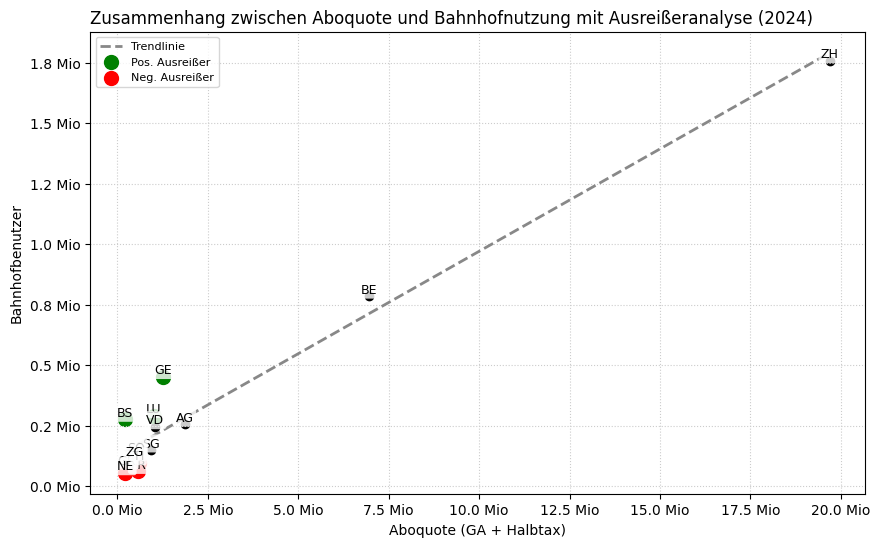

In [40]:


# Datei laden
df = pd.read_csv("final_bahnhof_abos.csv")

# Filter auf Jahr 2024
df_2024 = df[df["Jahr"] == 2024].copy()

# Aggregieren nach Kanton
df_2024_agg = df_2024.groupby("Kanton", as_index=False).agg({
    "Generalabonnement": "sum",
    "Halbtaxabonnement": "sum",
    "Anzahl Bahnhofbenutzer": "sum"
})

# Aboquote berechnen
df_2024_agg["Aboquote"] = df_2024_agg["Generalabonnement"] + df_2024_agg["Halbtaxabonnement"]

# Regressionslinie berechnen
x = df_2024_agg["Aboquote"].values
y = df_2024_agg["Anzahl Bahnhofbenutzer"].values
m, b = np.polyfit(x, y, 1)
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = m * x_vals + b

# Abweichung berechnen
df_2024_agg["Abweichung"] = y - (m * x + b)
top_pos = df_2024_agg.nlargest(3, "Abweichung")
top_neg = df_2024_agg.nsmallest(3, "Abweichung")

# Plot erstellen
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, color="#000000")

# Labels für Kantone
for _, row in df_2024_agg.iterrows():
    ax.text(row["Aboquote"], row["Anzahl Bahnhofbenutzer"], row["Kanton"],
            fontsize=9, ha='center', va='bottom',
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.8))

# Regressionslinie
ax.plot(x_vals, y_vals, color="#888888", linestyle="--", linewidth=2, label="Trendlinie")

# Ausreißer markieren
ax.scatter(top_pos["Aboquote"], top_pos["Anzahl Bahnhofbenutzer"], color="green", s=100, label="Pos. Ausreißer")
ax.scatter(top_neg["Aboquote"], top_neg["Anzahl Bahnhofbenutzer"], color="red", s=100, label="Neg. Ausreißer")

# Achsenformatierung
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f} Mio"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y/1e6:.1f} Mio"))

# Layout
ax.set_title("Zusammenhang zwischen Aboquote und Bahnhofnutzung mit Ausreißeranalyse (2024)", loc='left')
ax.set_xlabel("Aboquote (GA + Halbtax)")
ax.set_ylabel("Bahnhofbenutzer")
ax.grid(True, linestyle=":", color="#cccccc")
ax.set_facecolor("white")
ax.legend(fontsize=8, loc="upper left")

In [47]:


# Farben
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# Daten laden
df = pd.read_csv("final_bahnhof_abos.csv")

# Aggregation gesamtschweizerisch bis 2024
df_ch = df.groupby("Jahr", as_index=False)["Anzahl Bahnhofbenutzer"].sum()
df_ch = df_ch[df_ch["Jahr"] <= 2024]

# Lineare Regression trainieren
X = df_ch["Jahr"].values.reshape(-1, 1)
y = df_ch["Anzahl Bahnhofbenutzer"].values
model = LinearRegression().fit(X, y)

# Prognosejahre und Werte
forecast_years = np.array([2025, 2026, 2027]).reshape(-1, 1)
forecast_values = model.predict(forecast_years)

# Prognose-DataFrame
df_forecast = pd.DataFrame({
    "Jahr": forecast_years.flatten(),
    "Anzahl Bahnhofbenutzer": forecast_values,
    "Kanton": "CH"
})
df_forecast["Text"] = df_forecast["Anzahl Bahnhofbenutzer"].apply(lambda x: f"{x / 1e6:.1f} Mio")

# Original CH-Daten ebenfalls vorbereiten
df_ch["Kanton"] = "CH"
df_ch["Text"] = df_ch["Anzahl Bahnhofbenutzer"].apply(lambda x: f"{x / 1e6:.1f} Mio")

# Zusammenführen
df_ch_full = pd.concat([df_ch, df_forecast], ignore_index=True)

# Plot
fig = go.Figure()

# Beobachtete Werte
df_ch_obs = df_ch_full[df_ch_full["Jahr"] <= 2024]
fig.add_trace(go.Scatter(
    x=df_ch_obs["Jahr"],
    y=df_ch_obs["Anzahl Bahnhofbenutzer"],
    mode="lines+markers+text",
    name="CH (Beobachtung)",
    line=dict(color=IBCS_GRAY, width=2),
    marker=dict(color=IBCS_GRAY, size=6),
    text=df_ch_obs["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY)
))

# Prognosewerte
df_ch_pred = df_ch_full[df_ch_full["Jahr"] > 2024]
fig.add_trace(go.Scatter(
    x=df_ch_pred["Jahr"],
    y=df_ch_pred["Anzahl Bahnhofbenutzer"],
    mode="lines+markers+text",
    name="CH (Prognose)",
    line=dict(color=IBCS_GRAY, width=2, dash="dash"),
    marker=dict(color=IBCS_GRAY, size=6, symbol="diamond"),
    text=df_ch_pred["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY)
))

# Layout
fig.update_layout(
    title=dict(
        text="Zeitreihe tägliche Bahnhofnutzung CH mit Prognose (2025–2027)",
        x=0.01,
        xanchor="left",
        font=dict(size=16, color=IBCS_BLACK)
    ),
    xaxis=dict(
        title="Jahr",
        tickmode='linear',
        dtick=1,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    yaxis=dict(
        title="Bahnhofbenutzer",
        gridcolor="#dddddd",
        zeroline=False,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=500,
    width=900,
    showlegend=True
)

fig.show()

# Farben gemäss IBCS
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# CSV laden
df = pd.read_csv("final_bahnhof_abos.csv")
df = df[df["Jahr"] <= 2024]

# Daten aggregieren
df_abos = df.groupby("Jahr", as_index=False).agg({
    "Generalabonnement": "sum",
    "Halbtaxabonnement": "sum"
})

# Prognosefunktion
def prognose_fuer_spalte(df, spalte):
    X = df["Jahr"].values.reshape(-1, 1)
    y = df[spalte].values
    model = LinearRegression().fit(X, y)
    jahre = np.array([2025, 2026, 2027]).reshape(-1, 1)
    prognose = model.predict(jahre)
    return pd.DataFrame({"Jahr": jahre.flatten(), spalte: prognose})

# Prognosen erstellen
df_forecast_ga = prognose_fuer_spalte(df_abos, "Generalabonnement")
df_forecast_halbtax = prognose_fuer_spalte(df_abos, "Halbtaxabonnement")

# Kombinieren
df_full = df_abos.copy()
df_full = pd.concat([df_full, df_forecast_ga, df_forecast_halbtax], ignore_index=True)

# Formatlabels
df_full["GA_Label"] = df_full["Generalabonnement"].apply(lambda x: f"{x/1e6:.1f} Mio")
df_full["HT_Label"] = df_full["Halbtaxabonnement"].apply(lambda x: f"{x/1e6:.1f} Mio")

# Plot erstellen
fig = go.Figure()
farben = {"Generalabonnement": "#000000", "Halbtaxabonnement": "#666666"}
linienstile = {"ist": "solid", "prognose": "dash"}

# GA Plot
for typ in ["ist", "prognose"]:
    daten = df_full[df_full["Jahr"] <= 2024] if typ == "ist" else df_full[df_full["Jahr"] > 2024]
    fig.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Generalabonnement"],
        mode="lines+markers+text",
        name=f"Generalabo ({'Beobachtung' if typ == 'ist' else 'Prognose'})",
        line=dict(color=farben["Generalabonnement"], dash=linienstile[typ], width=2),
        marker=dict(size=6),
        text=daten["GA_Label"],
        textposition="top center",
        textfont=dict(size=9, color=farben["Generalabonnement"])
    ))

# Halbtax Plot
for typ in ["ist", "prognose"]:
    daten = df_full[df_full["Jahr"] <= 2024] if typ == "ist" else df_full[df_full["Jahr"] > 2024]
    fig.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Halbtaxabonnement"],
        mode="lines+markers+text",
        name=f"Halbtax ({'Beobachtung' if typ == 'ist' else 'Prognose'})",
        line=dict(color=farben["Halbtaxabonnement"], dash=linienstile[typ], width=2),
        marker=dict(size=6),
        text=daten["HT_Label"],
        textposition="top center",
        textfont=dict(size=9, color=farben["Halbtaxabonnement"])
    ))

# Layout
fig.update_layout(
    title=dict(
        text="Entwicklung und Prognose: General- und Halbtaxabonnemente (CH, 2013–2027)",
        x=0.01,
        xanchor="left",
        font=dict(size=16, color=IBCS_BLACK)
    ),
    xaxis=dict(
        title="Jahr",
        tickmode='linear',
        dtick=1,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    yaxis=dict(
        title="Anzahl Abonnemente",
        gridcolor="#dddddd",
        zeroline=False,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=600,
    width=950,
    showlegend=True
)

fig.show()





In [ ]:
"""# Farben gemäss IBCS
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# Finalen Datensatz laden
combined_df = pd.read_csv("final_bahnhof_abos.csv")

# Formatierungshilfe
def format_mio(x):
    return f"{x / 1e6:.1f} Mio"

# Zeitraum eingrenzen (ab 2013)
combined_df = combined_df[combined_df["Jahr"].between(2013, 2023)]

# Schweizweite Aggregation
df_ch = combined_df.groupby("Jahr")[["Anzahl Bahnhofbenutzer", "Generalabonnement", "Halbtaxabonnement"]].sum().reset_index()
df_ch["Kanton"] = "CH"

# Kantonale Aggregation
df_kanton = combined_df.groupby(["Jahr", "Kanton"])[["Anzahl Bahnhofbenutzer", "Generalabonnement", "Halbtaxabonnement"]].sum().reset_index()

# Liste aller Kantone
alle_kantone = sorted(df_kanton["Kanton"].unique())
start_kanton = "ZH"

# Funktion zur Erstellung eines Vergleichsdiagramms für eine Metrik
def create_f3_chart(metric, title, y_label):
    fig = go.Figure()

    for kanton in alle_kantone:
        sichtbar = (kanton == start_kanton)
        df_kt = df_kanton[df_kanton["Kanton"] == kanton]
        df_ch_tmp = df_ch.copy()

        # Linie: Kanton
        fig.add_trace(go.Scatter(
            x=df_kt["Jahr"],
            y=df_kt[metric],
            mode="lines+markers+text",
            name=kanton,
            visible=sichtbar,
            line=dict(color=IBCS_BLACK, width=2),
            marker=dict(color=IBCS_BLACK),
            text=[format_mio(v) for v in df_kt[metric]],
            textposition="top center",
            textfont=dict(size=9),
            legendgroup=kanton
        ))

        # Linie: CH-Vergleich (gestrichelt)
        fig.add_trace(go.Scatter(
            x=df_ch_tmp["Jahr"],
            y=df_ch_tmp[metric],
            mode="lines+markers+text",
            name="CH – Vergleich",
            visible=sichtbar,
            line=dict(color=IBCS_GRAY, width=2, dash="dot"),
            marker=dict(color=IBCS_GRAY),
            text=[format_mio(v) for v in df_ch_tmp[metric]],
            textposition="top center",
            textfont=dict(size=9),
            legendgroup=kanton,
            showlegend=False
        ))

    # Dropdown-Menü erstellen
    buttons = []
    for i, kanton in enumerate(alle_kantone):
        sichtbarkeit = [False] * (2 * len(alle_kantone))
        sichtbarkeit[2 * i] = True
        sichtbarkeit[2 * i + 1] = True
        buttons.append(dict(
            label=kanton,
            method="update",
            args=[
                {"visible": sichtbarkeit},
                {"title.text": f"{title} ({kanton} vs. CH, 2013–2023)"}
            ]
        ))

    # Layout
    fig.update_layout(
        title=dict(text=f"{title} ({start_kanton} vs. CH, 2013–2023)", x=0.01, xanchor="left"),
        xaxis=dict(title="Jahr", tickmode='linear', dtick=1, linecolor=IBCS_GRAY),
        yaxis=dict(title=y_label, gridcolor="#dddddd", linecolor=IBCS_GRAY),
        plot_bgcolor="white",
        paper_bgcolor="white",
        height=500,
        width=900,
        showlegend=False,
        updatemenus=[{
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
            "x": 1.05,
            "y": 1.15
        }]
    )
    return fig

# Diagramme erzeugen
fig1 = create_f3_chart("Anzahl Bahnhofbenutzer", "Bahnhofnutzung", "Bahnhofbenutzer pro Tag")
fig2 = create_f3_chart("Generalabonnement", "Generalabonnemente", "Anzahl GA")
fig3 = create_f3_chart("Halbtaxabonnement", "Halbtaxabonnemente", "Anzahl Halbtax")

# Anzeigen
fig1.show()
fig2.show()
fig3.show()"""



# Farben gemäss IBCS
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# Daten laden
df = pd.read_csv("final_bahnhof_abos.csv")

# Hilfsfunktion: Formatierung in Mio
def format_mio(x):
    return f"{x / 1e6:.1f} Mio"

# Bahnhofnutzung pro Jahr und Kanton (bis max. 2024)
df = df[df["Jahr"] <= 2024]
df_kanton = df.groupby(["Jahr", "Kanton"])["Anzahl Bahnhofbenutzer"].sum().reset_index()
df_kanton["Text"] = df_kanton["Anzahl Bahnhofbenutzer"].apply(format_mio)

# Gesamtschweiz berechnen
df_ch = df.groupby("Jahr")["Anzahl Bahnhofbenutzer"].sum().reset_index()
df_ch["Kanton"] = "CH"
df_ch["Text"] = df_ch["Anzahl Bahnhofbenutzer"].apply(format_mio)

# Alle Daten zusammenführen
df_all = pd.concat([df_kanton, df_ch], ignore_index=True)

# Liste aller Kantone
alle_kantone = sorted(df_all["Kanton"].unique())
alle_kantone.remove("CH")  # CH kommt separat als Referenz
start_kanton = "ZH"
start_index = alle_kantone.index(start_kanton)

# Plot erstellen
fig = go.Figure()

# CH-Vergleichslinie (immer sichtbar)
daten_ch = df_all[df_all["Kanton"] == "CH"]

fig.add_trace(go.Scatter(
    x=daten_ch["Jahr"],
    y=daten_ch["Anzahl Bahnhofbenutzer"],
    mode="lines+markers+text",
    name="CH (Referenz)",
    line=dict(color=IBCS_GRAY, width=2, dash="dot"),
    marker=dict(color=IBCS_GRAY, size=6),
    text=daten_ch["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY),
    visible=True,
    showlegend=False
))

# Kantone
for kanton in alle_kantone:
    sichtbar = (kanton == start_kanton)
    daten = df_all[df_all["Kanton"] == kanton]

    fig.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Anzahl Bahnhofbenutzer"],
        mode="lines+markers+text",
        name=f"{kanton}",
        visible=sichtbar,
        line=dict(color=IBCS_BLACK, width=2),
        marker=dict(color=IBCS_BLACK, size=6),
        text=daten["Text"],
        textposition="top center",
        textfont=dict(size=9, color=IBCS_BLACK),
        showlegend=False
    ))

# Dropdown-Buttons
buttons = []
for i, kanton in enumerate(alle_kantone):
    sichtbarkeit = [True]  # CH immer sichtbar
    for k in alle_kantone:
        sichtbar_k = (k == kanton)
        sichtbarkeit.append(sichtbar_k)
    buttons.append(dict(
        label=kanton,
        method="update",
        args=[
            {"visible": sichtbarkeit},
            {"title.text": f"Zeitreihe tägliche Bahnhofnutzung in {kanton} (2013–2024)"}
        ]
    ))

# Layout nach IBCS
fig.update_layout(
    title=dict(
        text=f"Zeitreihe tägliche Bahnhofnutzung in {start_kanton} (2013–2024)",
        x=0.01,
        xanchor="left",
        font=dict(size=16, color=IBCS_BLACK)
    ),
    xaxis=dict(
        title="Jahr",
        tickmode='linear',
        dtick=1,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    yaxis=dict(
        title="Bahnhofbenutzer",
        gridcolor="#dddddd",
        zeroline=False,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=500,
    width=900,
    showlegend=False,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "active": start_index,
        "x": 1.05,
        "y": 1.15
    }]
)

# Anzeige
fig.show()






"""##==== Zeitstrahl top 5 Kantone ====##
# Top 5 Kantone identifizieren
top5_kantone = mittelwerte_clean.sort_values(ascending=False).head(5).index.tolist()
gruppen = {"Top-Kantone": [], "Gruppiert": []}
for kanton in mittelwerte_clean.index:
    if kanton in top5_kantone:
        gruppen["Top-Kantone"].append(kanton)
    else:
        gruppen["Gruppiert"].append(kanton)

# Zeitstrahl Top 5
fig, ax = plt.subplots(figsize=(14, 6))
for kanton in gruppen["Top-Kantone"]:
    ax.plot(pivot_df_clean.index, pivot_df_clean[kanton], label=kanton, color="black", linestyle="-", linewidth=2)
gruppe_df = pivot_df_clean[gruppen["Gruppiert"]].sum(axis=1)
ax.plot(gruppe_df.index, gruppe_df, label="Andere Kantone (gruppiert)", color="gray", linestyle="--", linewidth=1.5)
ax.set_title("Tägliche Bahnhofbenutzer – Top 5 + Gruppierung (ohne 2013)")
ax.set_xlabel("Jahr")
ax.set_ylabel("Anzahl Bahnhofbenutzer pro Tag")
ax.set_xticks(pivot_df_clean.index)
ax.set_yticks([0, 500000, 1000000, 1500000, 1800000])
ax.set_yticklabels(["0", "500k", "1 Mio", "1.5 Mio", "1.8 Mio"])
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(title="Kanton", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Prognose mit linearer Regression (3 Jahre)
jahre = pivot_df_clean.index.to_numpy().reshape(-1, 1)
prognose_jahre = np.array([2024, 2025, 2026]).reshape(-1, 1)
alle_jahre = np.concatenate((jahre.flatten(), prognose_jahre.flatten()))

prognosen = {}
for kanton in gruppen["Top-Kantone"]:
    model = LinearRegression().fit(jahre, pivot_df_clean[kanton].to_numpy())
    prognosen[kanton] = model.predict(np.vstack((jahre, prognose_jahre)))

model = LinearRegression().fit(jahre, gruppe_df.to_numpy())
prognosen["Andere Kantone (gruppiert)"] = model.predict(np.vstack((jahre, prognose_jahre)))

plt.figure(figsize=(14, 6))
farben = ["black", "dimgray", "#333333", "#555555", "#777777"]
linienstile = ["--", "-.", ":", (0, (5, 1)), (0, (3, 3))]

for i, kanton in enumerate(gruppen["Top-Kantone"]):
    color = farben[i % len(farben)]
    linestyle = linienstile[i % len(linienstile)]
    plt.plot(jahre.flatten(), prognosen[kanton][:len(jahre)], linestyle="-", color=color, linewidth=2)
    plt.plot(prognose_jahre.flatten(), prognosen[kanton][len(jahre):], linestyle=linestyle, color=color, linewidth=2.5, label=f"{kanton}")

plt.plot(jahre.flatten(), prognosen["Andere Kantone (gruppiert)"][:len(jahre)], linestyle="-", color="lightgray", linewidth=1.5)
plt.plot(prognose_jahre.flatten(), prognosen["Andere Kantone (gruppiert)"][len(jahre):], linestyle=(0, (2, 2)), color="lightgray", linewidth=1.5, label="Andere (Prognose)")

plt.title("Zeitstrahl der Bahnhofbenutzer pro Tag – Historisch & Prognose")
plt.xlabel("Jahr")
plt.ylabel("Anzahl Bahnhofbenutzer pro Tag")
plt.xticks(ticks=alle_jahre, labels=[str(int(j)) for j in alle_jahre])
plt.yticks(ticks=[0, 500000, 1000000, 1500000, 1800000], labels=["0", "500k", "1 Mio", "1.5 Mio", "1.8 Mio"])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Kanton", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()"""

<br>

# **4. Informationen aufbereiten & präsentieren**

### Gesammtschweizerische & Kantonale Entwicklung der Bahnhofbenutzer & Abbonemente:

F1: Wie hat sich die Nutzung von Bahnhöfen kantonal & gesammtschweizerisch entwickelt zwischen 2013 und 2024? <br>

Zwischen 2013 und 2024 zeigt sich gesamtschweizerisch eine insgesamt wachsende Nutzung der Bahnhöfe, unterbrochen durch einen deutlichen Einbruch in den Jahren 2020 und 2021, bedingt durch die Corona-Pandemie. Danach erholten sich die Nutzerzahlen wieder, erreichten 2023 jedoch noch nicht in allen Kantonen das Vorkrisenniveau.

Kantonal fällt auf, dass urbane Kantone wie Zürich (ZH), Bern (BE), Waadt (VD) und Genf (GE) über den gesamten Zeitraum hinweg deutlich höhere absolute Nutzungszahlen verzeichnen als ländliche Regionen. Diese Kantone sind auch Treiber des nationalen Anstiegs. In kleineren Kantonen (z. B. UR, AI, OW) blieb die Nutzung über die Jahre relativ konstant und auf niedrigem Niveau.
<br>

/content/CH_KT_BHF.png
<br>
<br>

F2: Wie haben sich die Abozahlen kantonal & gesammtschweizerisch entwickelt zwischen 2013 und 2024?

Gesamtschweizerisch:

- Halbtaxabonnemente: Die Anzahl der Halbtaxabonnemente ist im Zeitraum 2013-2024 kontinuierlich gestiegen und erreichte 2024 mit über 3.5 Millionen Abos ihren Höchststand. Einzig im Jahr 2020 war ein leichter Rückgang aufgrund der COVID-19-Pandemie zu verzeichnen.
Generalabonnemente (GA): Auch die Anzahl der GA ist im Betrachtungszeitraum stetig angestiegen. Nach einem kurzzeitigen Rückgang im Jahr 2020 erholten sich die Zahlen schnell und erreichten 2024 mit über 600'000 Abos ein neues Rekordhoch.
Kantonal:

- Halbtaxabonnemente: Die Entwicklung der Halbtaxabonnemente verläuft in den meisten Kantonen parallel zum schweizerischen Trend, wobei die urbanen Kantone wie Zürich, Bern und Waadt die grössten absoluten Zahlen aufweisen. In einigen Kantonen, wie z.B. Genf oder Basel-Stadt, ist im Vergleich zur Gesamtschweiz ein überdurchschnittliches Wachstum zu beobachten.
Generalabonnemente (GA): Ähnlich wie beim Halbtax zeigen auch die GA in den urbanen Kantonen die höchsten absoluten Zahlen. Hier sind Zürich, Bern, Waadt und Aargau die Kantone mit den meisten GA. Im Vergleich zur Gesamtschweiz zeigen einige Kantone, wie z.B. Zug oder Schwyz, ein überdurchschnittliches Wachstum.

Kantonal:

- Halbtaxabonnemente: Die Entwicklung der Halbtaxabonnemente verläuft in den meisten Kantonen parallel zum schweizerischen Trend, wobei die urbanen Kantone wie Zürich, Bern und Waadt die grössten absoluten Zahlen aufweisen. In einigen Kantonen, wie z.B. Genf oder Basel-Stadt, ist im Vergleich zur Gesamtschweiz ein überdurchschnittliches Wachstum zu beobachten.
- Generalabonnemente (GA): Ähnlich wie beim Halbtax zeigen auch die GA in den urbanen Kantonen die höchsten absoluten Zahlen. Hier sind Zürich, Bern, Waadt und Aargau die Kantone mit den meisten GA. Im Vergleich zur Gesamtschweiz zeigen einige Kantone, wie z.B. Zug oder Schwyz, ein überdurchschnittliches Wachstum.

/content/CH_KT_HT.png
/content/CH_KT_GA.png
<br>
<br>
F3 Was sind die Trends für die Jahre 2023 bis 2026?

Die Prognose für die Bahnhofnutzer wurde mithilfe einer linearen Regression auf Basis der historischen Daten von 2013 bis 2024 erstellt. Der Trend zeigt einen kontinuierlichen Anstieg der Bahnhofsnutzung in der Schweiz. Für die Jahre 2025, 2026 und 2027 wird eine weitere Zunahme der täglichen Bahnhofsnutzer erwartet, die auf 1.94 Millionen, 1.99 Millionen und 2.04 Millionen ansteigen könnte.

Die Prognose für die Abos (Halbtax & GA) wurde ebenfalls mithilfe einer linearen Regression auf Basis der historischen Daten von 2013 bis 2024 erstellt. Die Trendlinien zeigen ein kontinuierliches Wachstum sowohl für Halbtax- als auch für GA-Abonnemente. Es wird prognostiziert, dass die Anzahl der Halbtax-Abos in den Jahren 2025, 2026 und 2027 auf 3.79 Millionen, 3.89 Millionen bzw. 3.99 Millionen ansteigen wird.
Für die GA-Abos wird ein Anstieg auf 663'000, 689'000 bzw. 715'000 in den Jahren 2025, 2026 und 2027 prognostiziert.

/content/Trend_CH.png
/content/CH_Prog_GA_HT.png
<br>
<br>
F4: Welche Kantone weichen besonders stark vom nationalen Trend ab z.B. mit hoher Aboquote, aber geringer Bahnhofnutzung oder umgekehrt?

Der Vergleich von Aboquote und Bahnhofnutzung zeigt, dass einige Kantone deutlich vom nationalen Trend abweichen. Genf, Zürich und Basel-Stadt verzeichnen eine höhere Bahnhofnutzung als aufgrund ihrer Abozahlen zu erwarten wäre – vermutlich wegen starkem Pendelverkehr, internationaler Verbindungen und urbaner Dichte.

Umgekehrt zeigen Tessin, Wallis und Uri trotz hoher Aboquote eine unterdurchschnittliche Bahnhofnutzung. Dies lässt sich durch Freizeit- oder Tourismusnutzung, begrenzte ÖV-Anbindung oder Transitverbindungen erklären. Die Analyse zeigt: Die Aboquote allein reicht nicht aus, um die Nutzungsmuster vollständig zu erklären.
<br>
<br>

STOPPED HERE!!!



F5: Gibt es einen Zusammenhang zwischen der Anzahl Generalabonnemente und der Bahnhofnutzung pro Kanton?

-> Geht eine höhere Bahnhofnutzung mit einer Steigerung der Abozahlen inher? -> Können höhere Abozahlen ein Indikator sein, für steigende Bahnhofnutzung?
<br>
<br>

F7: Entwickeln sich Halbtax- und GA-Abos parallel oder unabhängig voneinander?



# **5. Datenbasierte Entscheidungen treffen**

Zum Abschluss werden Kantone identifiziert, die besonders stark vom nationalen Durchschnitt abweichen. Daraus lassen sich Hypothesen zu regionalem Mobilitätsverhalten, Infrastruktur oder Angebotsnutzung ableiten.

<br>